# Data Science in Psychology & Neuroscience (DSPN): 

## Lecture 15. Data Modeling (part 1)

### Date: October 15, 2020

### To-Dos From Last Class:

* Assignment #4: <a href="https://www.dropbox.com/request/QRN3YlXMeh3okGCA8SMG">Data Visualization</a> (before 10/15, 23:00 MDT)
    
### Today:

* Regression
* Correlation
* One-Way ANOVA
* Repeated measures ANOVA
* Linear Mixed-Effects Models

### Homework

* Assignment #4: <a href="https://www.dropbox.com/request/QRN3YlXMeh3okGCA8SMG">Data Visualization</a> (before 10/15, 23:00 MDT)

In [1]:
# plot theme stuff
# Many palettes available online, can customize
# these are from: https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=9
my_palette <- c("#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00")

# This is the basic function I use for all the ggplots I create. 
# Modified from this black themed ggplot function: https://gist.github.com/jslefche/eff85ef06b4705e6efbc
my_theme = function(base_size = 24, base_family = "") {
  
  theme_grey(base_size = base_size, base_family = base_family) %+replace%
    
    theme(
      # Specify axis options
      axis.line = element_blank(),  
      axis.text.x = element_text(size = base_size*0.8, color = "black", lineheight = 0.9),  
      axis.text.y = element_text(size = base_size*0.8, color = "black", lineheight = 0.9),  
      axis.ticks = element_line(color = "black", size  =  0.2),
      axis.title.x = element_text(size = base_size, color = "black", margin = margin(10, 0, 0, 0)),
      axis.title.y = element_text(size = base_size, color = "black", angle = 90, margin = margin(0, 10, 0, 0)),  
      axis.ticks.length = unit(0.3, "lines"),   
      # Specify legend options
      legend.background = element_rect(color = NA, fill = "#ffffff"),  
      legend.key = element_rect(color = "black",  fill = "#ffffff"),  
      legend.key.size = unit(2, "lines"),  
      legend.key.height = NULL,  
      legend.key.width = NULL,      
      legend.text = element_text(size = base_size*0.8, color = "black"),  
      legend.title = element_text(size = base_size*0.8, face = "bold", hjust = 0, color = "black"),
      legend.position = "right",  
      legend.text.align = NULL,  
      legend.title.align = NULL,  
      legend.direction = "vertical",  
      legend.box = NULL, 
      # Specify panel options
      panel.background = element_rect(fill = "#ffffff", color  =  NA),  
      panel.border = element_rect(fill = NA, color = "black"),  
      panel.grid.major = element_line(color = "#ffffff"),  
      panel.grid.minor = element_line(color = "#ffffff"),  
      panel.spacing = unit(2, "lines"),
      # Specify facetting options
      strip.background = element_rect(fill = "grey30", color = "grey10"),  
      strip.text.x = element_text(size = base_size*0.8, color = "black"),  
      strip.text.y = element_text(size = base_size*0.8, color = "black",angle = -90),  
      # Specify plot options
      plot.background = element_rect(color = "#ffffff", fill = "#ffffff"),  
      plot.title = element_text(size = base_size*1.2, color = "black"),  
      plot.margin = unit(rep(1, 4), "lines")
    ) 
}

# So you want to model some data...

<img src='img/decision_tree.png' width='500'>

## Table 1: Summarizing the pros / cons

| Type of Model | Distribution Assumptions | Characteristics | Sensitivity to violations |
| --- | --- | --- | --- |
| parametric | specific, inflexible | optimal when assumptions are met | Very high |
| robust | parametric, allowing some flexibility | good performance in many situations | Moderate |
| nonparametric | no assumptions | Sub-optimal, but acceptable across almost any distribution | Not at all |

* Data science in practice: 
    * If assumptions not violated, use standard parametric models. 
    * If violated a bit (often the case in psych and neuro) use robust variants.
    * If your data are truly wacky, use nonparametric models.
        * In class, only nonparametric test I'll cover is Spearman's _rho_.
   
For a thoughtful discussion on these issues: <a href="https://www.sciencedirect.com/science/article/pii/S0005796717301067">Field & Wilcox. (2017).</a>

# Questions to ask yourself:
1. What is the hypothesis you're testing?
    1. Variables?
    2. Directional?
2. Are the data going to problematic / violate GLM assumptions?
    1. Outliers? 
    2. Normality? 
    3. Equal variances?
    
* Only after understanding 1-2, test a statistical model.

# Example: Age-related changes in Fluid and Crystallized cognition in young adults

## NIH Toolbox Cognition Battery

<img src='img/nih_tb.jpg' width='500'>

* Our hypotheses: 
    1. Fluid intelligence will _decrease_ as a function of age.
    2. Crystallized intelligence will _increase_ as a function of age.

## Preamble before we get started...

In [3]:
library(tidyverse)

# loading the hcp_alldat.csv file
data <- 'misc_exercises/hcp_alldat.csv'
df <- read_csv(data)

# how many subjects do we have?
nsubs_arr = unique(df$Subject)
nsubs = length(nsubs_arr)
paste('the number of participants in the dataset is ≈',nsubs,sep=' ')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”
Warning message:
“package ‘tibble’ was built under R version 3.5.2”
Warning message:
“package ‘tidyr’ was built under R version 3.5.2”
Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  .default = col_double(),
  Subject = col_integer(),
  Release = col_character(),
  Acquisition = col_character(),
  Gender = col_character(),
  Age = col_character(),
  `3T_Full_MR_Compl` = col_logical(),
  T1_Count = col_integer(),
  T2_Count = col_integer(),
  `3T_RS-fMRI_Count` = col_integer(),
  

[1] "the number of participants in the dataset is ≈ 1112"

### Question 1A: What are my variables

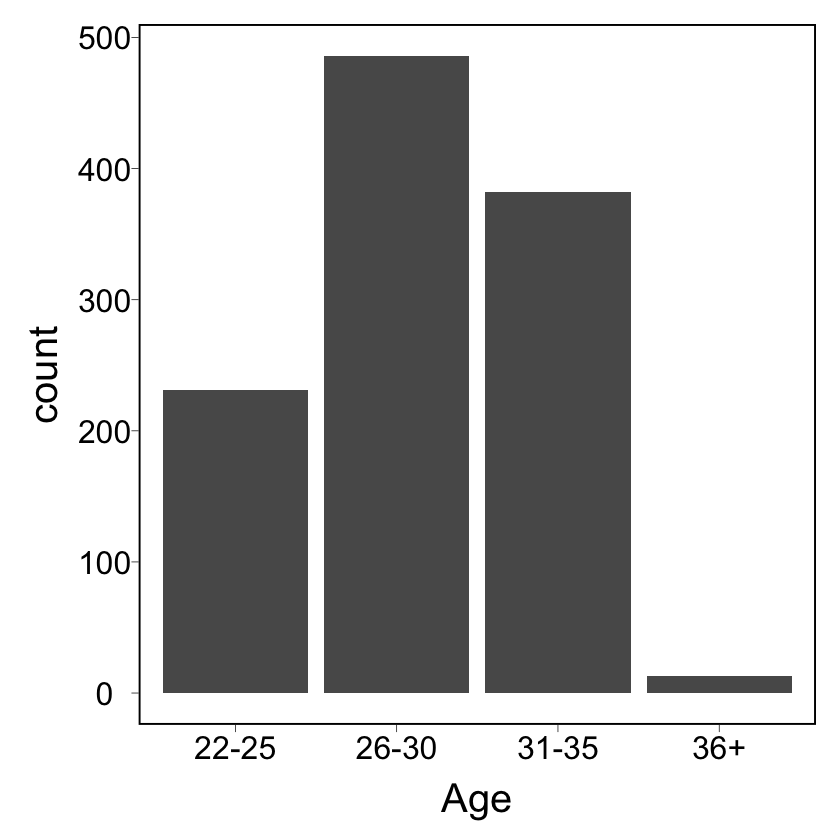

In [4]:
# What does the age variable look like?
ggplot(df,aes(x = Age)) +
    geom_bar() +
    my_theme()

# Compute ordinal age variable
df <- df %>%
    mutate(Age_ord = ifelse(Age=='22-25',1,
                           ifelse(Age=='26-30',2,3)))

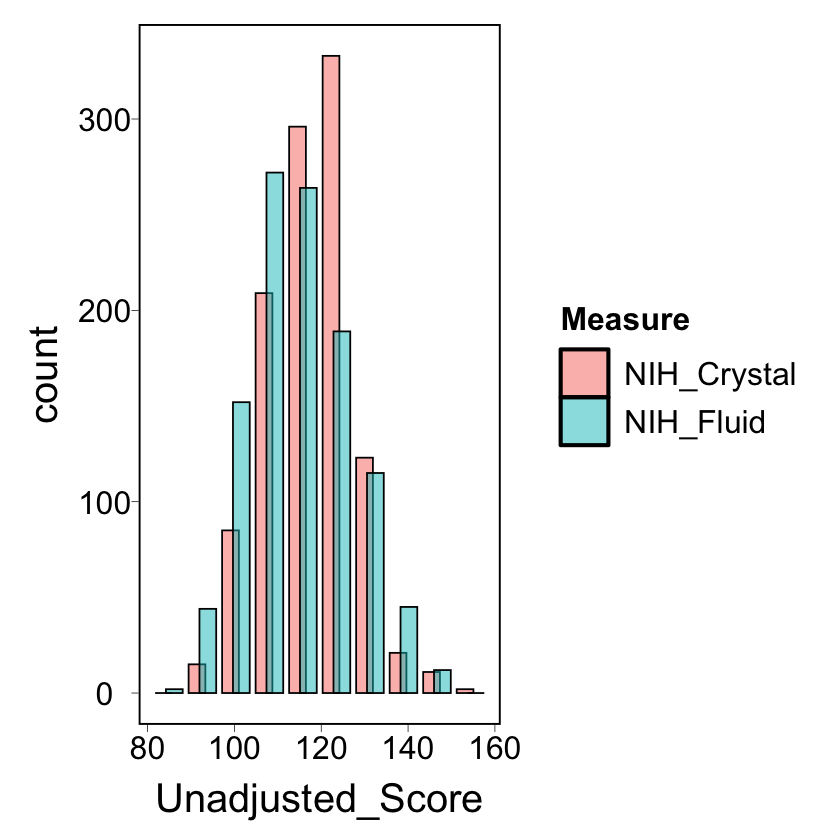

In [5]:
# visualize fluid and crystallized cog ability

plot_df <- df %>%
    select(Subject,CogCrystalComp_Unadj,CogFluidComp_Unadj) %>%
    na.omit() %>%
    rename(NIH_Fluid='CogFluidComp_Unadj',
          NIH_Crystal='CogCrystalComp_Unadj') %>%
    pivot_longer(cols = starts_with('NIH_'),
                 names_to = 'Measure',
                 values_to = 'Unadjusted_Score')

# plot a histogram of the data
ggplot(plot_df, aes(x = Unadjusted_Score, fill = Measure)) +
    geom_histogram(position=position_dodge(5),bins=10,alpha=0.5,colour='black') +
    my_theme()

### Question 1B: Directional?

* We're interested in how age and cognitive function are related. 
    * Is there a direction implicit to this question?

## Revisiting: Questions to ask yourself...
1. ~~What is the hypothesis you're testing?~~ 
<span style="background-color: #FFFF00">Our hypotheses: 1. Fluid intelligence will _decrease_ as a function of age.; 2. Crystallized intellience will _increase_ as a function of age.</span>

    1. ~~Variables?~~
    
    <span style="background-color: #FFFF00">Age, NIH-Fluid, NIH-Crystallized</span>
    
    2. ~~Directional?~~
    
    <span style="background-color: #FFFF00">NIH ~ Age</span>

<img src='img/decision_tree_dir.png' width='500'>
    
2. Are the data going to problematic / violate GLM assumptions?
    1. ~~Outliers?~~ <span style="background-color: #FFFF00">Yes, probably!</span>
    2. ___Normality?___
    3. ___Equal variances?___

In [6]:
# testing the normality of fluid cognitive ability
shapiro.test(df$CogFluidComp_Unadj)

# testing the normality of crystalized cog ability
mod <- shapiro.test(df$CogCrystalComp_Unadj)
print(mod)
# routinize which model to run based on shapiro result
if(mod$p.value<0.05){
    print('run a nonparametric or robust test!')
    # insert the model code here
}


	Shapiro-Wilk normality test

data:  df$CogFluidComp_Unadj
W = 0.98943, p-value = 4.245e-07



	Shapiro-Wilk normality test

data:  df$CogCrystalComp_Unadj
W = 0.99584, p-value = 0.004382

[1] "run a nonparametric or robust test!"


In [7]:
# Homoscedasticity across a 2-level factor
var.test(CogFluidComp_Unadj ~ Gender, data=df)

# Homoscedasticity across a k-level factor
bartlett.test(df$CogFluidComp_Unadj,df$Age_ord)
bartlett.test(df$CogCrystalComp_Unadj,df$Age_ord)


	F test to compare two variances

data:  CogFluidComp_Unadj by Gender
F = 0.87951, num df = 594, denom df = 500, p-value = 0.1337
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7427383 1.0401826
sample estimates:
ratio of variances 
         0.8795101 



	Bartlett test of homogeneity of variances

data:  df$CogFluidComp_Unadj and df$Age_ord
Bartlett's K-squared = 8.6589, df = 2, p-value = 0.01318



	Bartlett test of homogeneity of variances

data:  df$CogCrystalComp_Unadj and df$Age_ord
Bartlett's K-squared = 5.9097, df = 2, p-value = 0.05209


# Let's model the data!

* Our independent variable
    * Age
* Our dependent variables
    * NIH-Fluid
    * NIH-Crystallized
* Our model of choice
    * Regression -- Robust variant (MM-type estimators)
    * Can compare to ordinary least squares (OLS) regression model

In [9]:
# Run the standard OLS lm model on fluid cognitive ability

In [10]:
# Run the robust variant on fluid cognitive ability

In [ ]:
# Run the standard OLS lm model on crystallized cognitive ability

In [ ]:
# Run the robust variant on crystallized cognitive ability

In [11]:
# Visualize the relationships

# What if we had a covariate to include?

* e.g. Control for variance in internalizing psychopathology

In [13]:
# Run the a robust model on fluid cog ~ age + sadness

# What if we didn't have a directional prediction?

* e.g. Association between fluid and crystallized

<img src='img/decision_tree_undir.png' width='500'>

In [14]:
# Run a standard correlation between fluid and crystallized

In [15]:
# Run a ranked correlation between fluid and crystallized

# What if we wanted to make a specific inference about group __differences__?

* e.g. Which age group differs from the others wrt fluid intelligence?

<img src='img/decision_tree_diffs.png' width='500'>

### Let's also try a Robust Bootstrap version of the one-way ANOVA...
* Test the hypothesis of equal __trimmed__ means using a bootstrap method.
    * https://rdrr.io/rforge/WRS2/man/t1waybt.html

# Repeated-Measures ANOVA

* e.g. Testing for age-related changes on specific fluid cog subscales

* Repeated-Measures ANOVA with a bw subjects factor

| Participant | Age | flexibility (DCCS) | inhibition (Flanker) | processing speed (PCPS) |
| --- | --- | --- | --- | --- |
| S1 | S1_Age | S1_DCCS |  S1_Flanker | S1_PCPS |
| S2 | S2_Age | S2_DCCS |  S2_Flanker | S2_PCPS |
| ... | ... | ... | ... | ... |
| Sn | Sn_Age | Sn_DCCS |  Sn_Flanker | Sn_PCPS |

<img src='img/LMMs.png' width='500'>

Wonderful (relatively brief) intro lecture: https://www.youtube.com/watch?v=QCqF-2E86r0

## Things that often muck up regression and rm-anova 
* Inability to accommodate 
* Nested factors (e.g. stimulus identity:condition, participant:testing site, etc.)
* Missing data & unbalanced designs (e.g. if we had test-retest on some but not all subjects)
* Repeats as a continuous factor (e.g. time for longitudinal studies)

## LMMs are more flexible, but a bit more esoteric


* Incorporate fixed and random effects. 
    * Fixed:  Data has been gathered from all levels that are of interest.
        * Example: N-back 2 vs 0 -- We don't intend to say anything about 3-back.
        * Indicators:
            * Primary independent variable(s) of interest.
            * Secondary covariates you want to control for (e.g. demographic vars).
            * Only has 2 levels.
    * Random: If the levels of a factor are randomly sampled from a population, it is random.
        * Example: Subject, testing site, etc.
        * Indicators:
            * Not of interest, but want to account for variance.
            * Want to generalize conclusions to entire population.
            * Any interaction with a random factor.

## Interpretation
* The model designates that the slope and intercept of the regression line are fixed by the pooled data.
    * Fixed effects intercept and coefficients pooled across random FX.
* Random effect intercepts and slopes allowed to vary randomly.
    * In lmer output, we only get information about the extent of variance.
    * <a href="https://www.rdocumentation.org/packages/lme4/versions/1.1-23/topics/ranef">ranef</a> for more info. on random FX.
    
## We can also do a robust variant of the LMM...